In [1]:
import pandas as pd

In [2]:
bitcoin = pd.read_csv('datasets/coin_Bitcoin.csv')
bitcoin.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [3]:
bitcoin.tail()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11
2990,2991,Bitcoin,BTC,2021-07-06 23:59:59,35038.536363,33599.916169,33723.509655,34235.193451,2.650126e+10,6.418992e+11


In [4]:
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin.set_index('Date', inplace=True)
bitcoin.index.freq = 'D'
bitcoin.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


<Axes: xlabel='Date'>

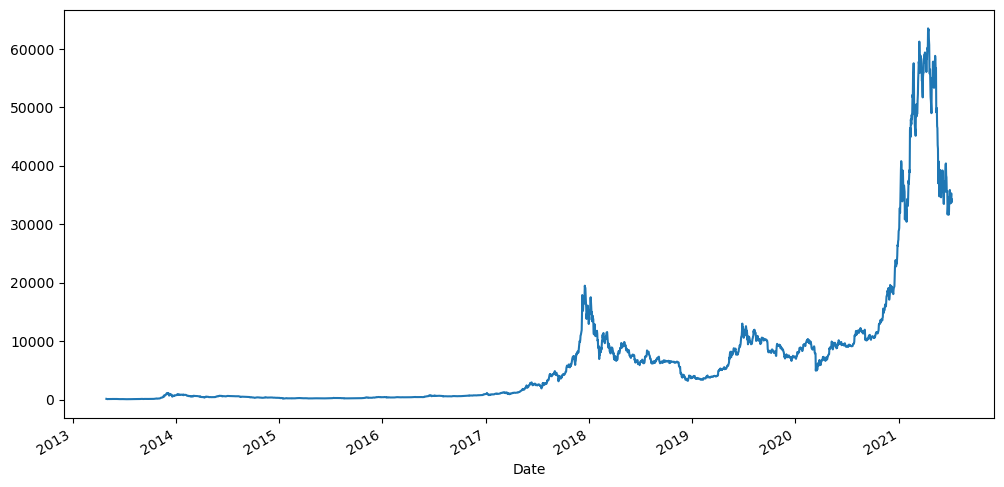

In [5]:
bitcoin['Close'].plot(figsize=(12, 6))

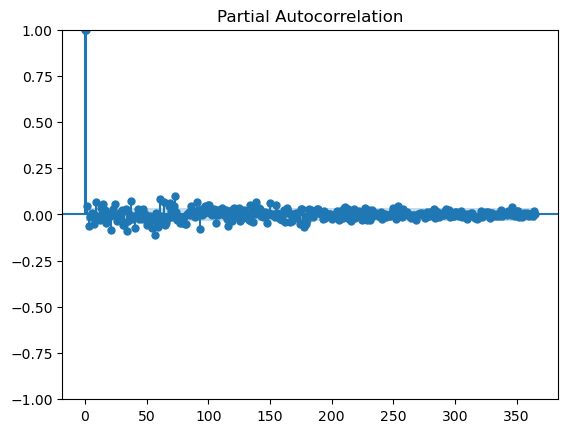

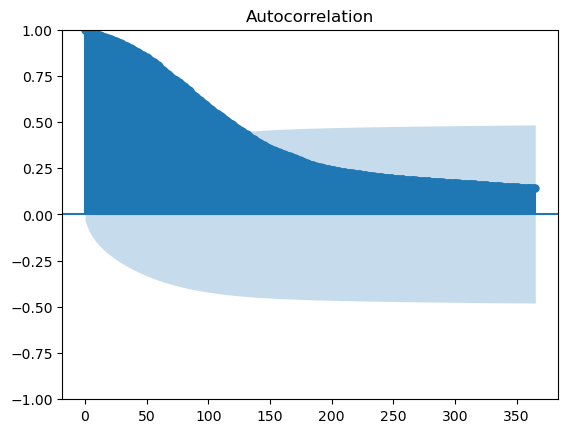

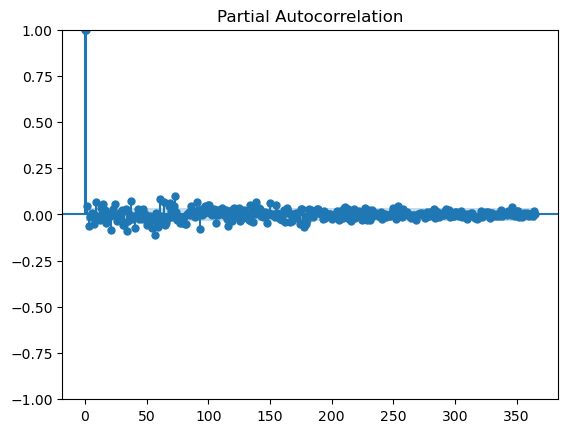

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(bitcoin['Close'], lags=365)
plot_pacf(bitcoin['Close'], lags=365)

In [37]:
lag_count = 15
bitcoin_lagged = bitcoin[['Close']].copy()
for i in range(lag_count,0,-1):
    bitcoin_lagged['t='+str(i)] = bitcoin_lagged['Close'].shift(i)
bitcoin_lagged.dropna(inplace=True)
bitcoin_lagged.head()

,Close,t=15,t=14,t=13,t=12,t=11,t=10,t=9,t=8,t=7,t=6,t=5,t=4,t=3,t=2,t=1
Date,,,,,,,,,,,,,,,,
2013-05-14 23:59:59,111.500000,144.539993,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,115.000000,117.980003
2013-05-15 23:59:59,114.220001,139.000000,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,115.000000,117.980003,111.500000
2013-05-16 23:59:59,118.760002,116.989998,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,115.000000,117.980003,111.500000,114.220001
2013-05-17 23:59:59,123.014999,105.209999,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,115.000000,117.980003,111.500000,114.220001,118.760002
2013-05-18 23:59:59,123.498001,97.750000,112.500000,115.910004,112.300003,111.500000,113.566002,112.669998,117.199997,115.242996,115.000000,117.980003,111.500000,114.220001,118.760002,123.014999


In [38]:
train = bitcoin_lagged.iloc[:-15]
test = bitcoin_lagged.iloc[-15:]

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = train.drop('Close', axis=1)
y = train['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [40]:
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)*100

2.8169232782727818

In [ ]:
import numpy as np


def get_first_eval_batch(data, n):
    return data[-n:].reshape(-1, n)

def make_predictions(train_data, test_data, model, lag_count):
    test_prediction_rfr = []
    current_batch = get_first_eval_batch(train_data, lag_count)

    for i in range(len(test_data)):
        current_batch_df = pd.DataFrame(current_batch, columns=X_train.columns)
        current_pred = model.predict(current_batch_df)[0]
        test_prediction_rfr.append(current_pred)
        current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, lag_count)
    return test_prediction_rfr



test_prediction_rfr = make_predictions(train['Close'].values, test['Close'].values, model, lag_count)

In [ ]:
mean_absolute_percentage_error(test['Close'], test_prediction_rfr)*100

8.583503647228476

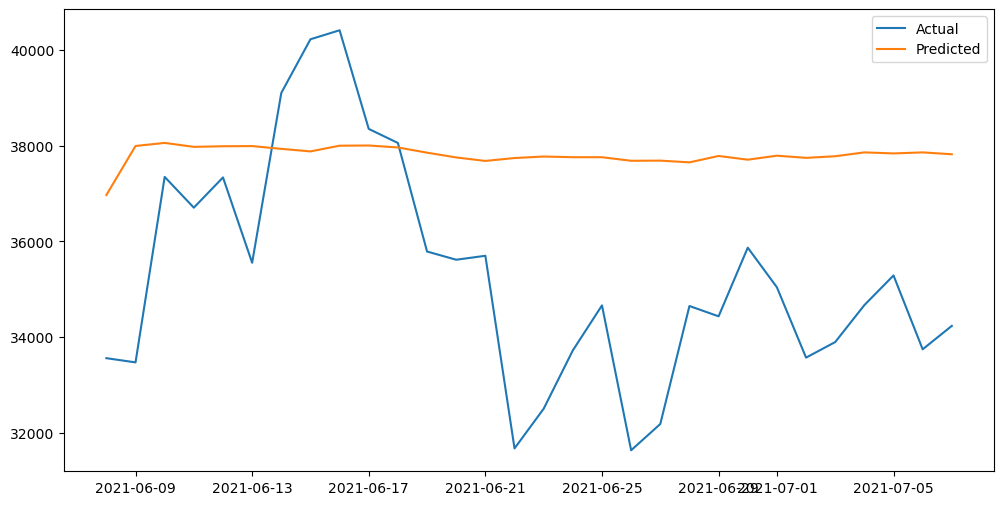

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, test_prediction_rfr, label='Predicted')
plt.legend()
plt.show()